<a href="https://colab.research.google.com/github/Chay16/dataflowr-PlutonAI/blob/master/06_AE_NoisyAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised learning with Autoencoder

We first play with MNIST dataset and pieces of code seen during the course.

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

## Loading MNIST

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [5]:
# to be modified if not on colab
root_dir = './data/MNIST/'
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Helper Functions

In [6]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [0]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

Why did we take 784 as input dimension?

To find the learning rate, see the documentation for [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [0]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [10]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.124655
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.046309
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.031571
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.030374
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.025613
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.022501
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.022306
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.019670
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.018690
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.018267
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.018283
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.017572
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.017365
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.016401
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.017780
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.018329
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.017864
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.017786
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.016799
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.017083
Train Epoch: 6 [51200/60000 (85%)]	

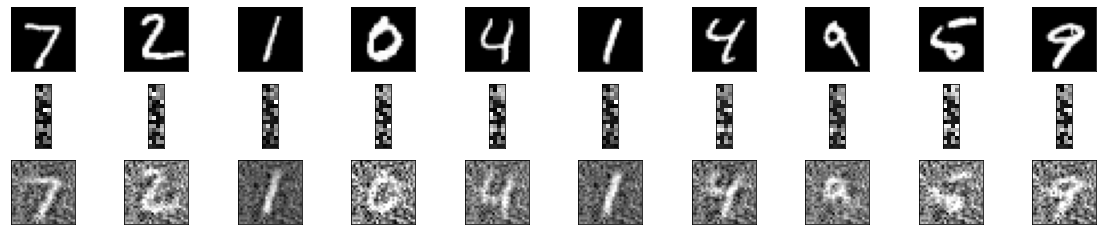

In [11]:
plot_reconstructions(model)

## 1. Exercise: Stacked Autoencoder

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and then the code of dimension 32. For the decoder, you can take the same sequence of dimensions in reverse order.

In [0]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        #
        # your code here
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, encoding_dim), 
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, input_dim),
        )
        #
        
    def forward(self, x):
        #
        # your code here
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded
        #

In [0]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [14]:
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.115357
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.049786
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.036796
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.034610
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.030025
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.028142
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.026009
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.024164
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.023409
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.024333
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.023156
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.022704
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.022691
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.021351
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.021424
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.021141
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.020195
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.019983
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.019795
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.020016
Train Epoch: 6 [51200/60000 (85%)]	

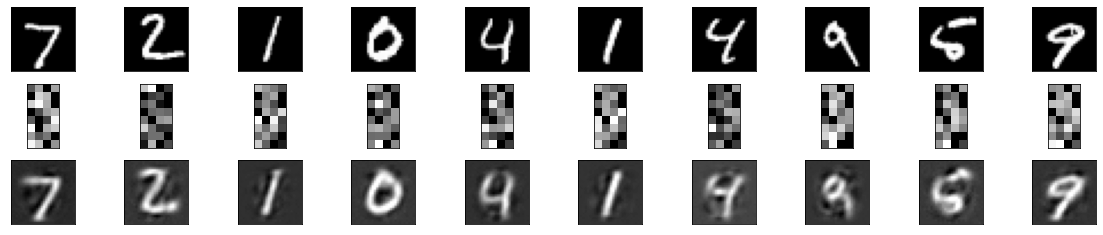

In [15]:
plot_reconstructions(model)

Replace the `MSELoss` with a `BCEWithLogitsLoss` for each pixel. Note the unusual use of `BCEWithLogitsLoss`! You can have a look at the definition of [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy).

In [16]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.694675
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.258323
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.245227
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.234705
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.218493
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.193358
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.187576
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.166909
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.160064
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.163467
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.156074
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.148047
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.144214
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.149295
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.140440
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.140575
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.139713
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.133479
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.134737
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.136135
Train Epoch: 6 [51200/60000 (85%)]	

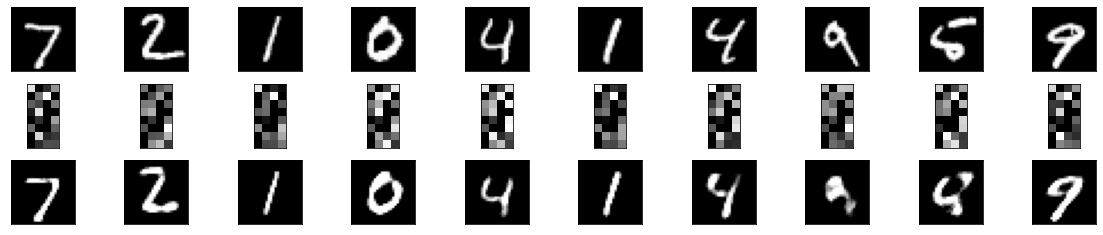

In [17]:
plot_reconstructions(model)

## 2. Optional

At this stage, you can code the interpolation described in the lesson to obtain:

![](https://raw.githubusercontent.com/mlelarge/dataflowr-slides/master/PlutonAI/images/lesson6/interp_AE.png)

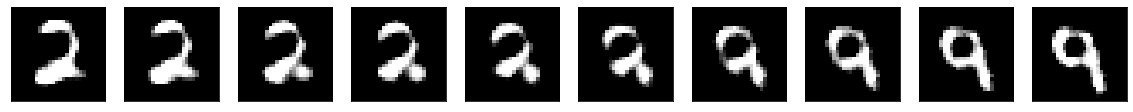

In [21]:
N_img = 10

alphas = np.linspace(0,1,N_img)
images, labels = next(iter(train_loader))
image_2 = images[labels == 2][0]
image_9 = images[labels == 9][0]

encoded_2 = model.encoder(image_2.view([-1, 784]).to(device))
encoded_9 = model.encoder(image_9.view([-1, 784]).to(device))

plt.figure(figsize=(20, 10))


for i in range(N_img):
    alpha = alphas[i]
    encoded = (1 - alpha) * encoded_2 + alpha * encoded_9
    decoded = model.decoder(encoded)
    interpolation = to_img(decoded)[0]

    ax = plt.subplot(1, N_img, i+1)
    plt.imshow(interpolation)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# 3. Exercise: Implement a denoising AE:


Use previous code and with minimal modifications, transform your AE in a denoising AE. Now, you first apply some noise to your input and try to recover the original data at the output. For the noise, you can add some random noise or erase some of the pixels. In this last case, you should obtain something like: 

![](https://raw.githubusercontent.com/mlelarge/dataflowr-slides/master/PlutonAI/images/lesson6/denoising_AE.png)

The first line corresponds to the original digit, the second line to the noisy version of the digit given as input to your network, the third line is the associated code amd the last line is the denoised digit obtained by your decoder from the code.

In [0]:
# You need first to modify the training process by adding noise to your data
# Hint if you want to erase pixels: https://stackoverflow.com/questions/49216615/is-there-an-efficient-way-to-create-a-random-bit-mask-in-pytorch
def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
      for batch_idx, (data, _) in enumerate(train_loader):
        #
        # your code here to create the noisy_data
        data = data.to(device)
        noisy_data = data + noise*torch.randn(data.size()).to(device)
        data = data.view([-1,784])
        noisy_data = noisy_data.view([-1, 784])

        #
        optimizer.zero_grad()
        output = model(noisy_data)
        loss = loss_fn(output, data)
        loss.backward()
        optimizer.step()
            
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

In [0]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [27]:
train_denoiser(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer, noise=0.8)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.694136
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.257474
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.237771
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.240704
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.221645
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.206718
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.192641
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.195448
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.185199
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.181221
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.182353
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.168338
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.165421
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.169033
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.164105
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.167376
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.168398
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.167432
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.163653
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.159213
Train Epoch: 6 [51200/60000 (85%)]	

In [0]:
# Now you need to modify the plot function
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits, 
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    #
    # your code here to compute
    # noisy_data
    # encoded_imgs
    # decoded_imgs
    noisy_data = data.to(device) + noise*torch.randn(data.size()).to(device)
    noisy_data = noisy_data.view([-1,784])
    encoded_imgs = model.encoder(noisy_data)
    decoded_imgs = model.decoder(encoded_imgs)
    #
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

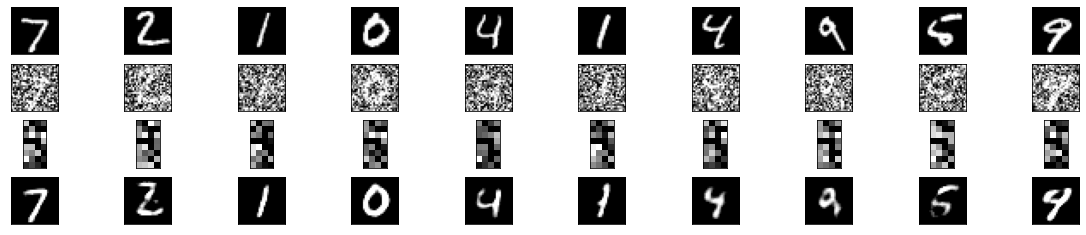

In [33]:
plot_denoising(model, noise=0.8)